In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import pygame
import random
from collections import deque

# See environment
Just sample a random game and view the results

In [193]:
# Create the environment
env = gym.make('CartPole-v1', render_mode="human")

# Reset the environment to get the initial state
state = env.reset()

# Run a random policy for a few episodes
for episode in range(5):
    state, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        env.render()  # Render the environment

        # Take a random action
        action = env.action_space.sample()

        # Step the environment with the chosen action
        state, reward, done, truncated, info = env.step(action)
        total_reward += reward

        if done or truncated:
            break

    print(f"Episode {episode + 1}: Total Reward: {total_reward}")

env.close()

Episode 1: Total Reward: 17.0
Episode 2: Total Reward: 20.0
Episode 3: Total Reward: 15.0
Episode 4: Total Reward: 15.0
Episode 5: Total Reward: 13.0


# Create a replay buffer
The replay buffer stores previous experiences like, states, actions, rewards, next states and if the simulation ended (dones)

In [21]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed=42, device='cpu'):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.device = device

    def add(self, experience):
        self.memory.append(experience)

    def sample(self):
        experiences = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return (
            torch.tensor(np.array(states), dtype=torch.float32, device=self.device),
            torch.tensor(np.array(actions), dtype=torch.int64, device=self.device),
            torch.tensor(np.array(rewards), dtype=torch.float32, device=self.device),
            torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device),
            torch.tensor(np.array(dones), dtype=torch.uint8, device=self.device)
        )

    def __len__(self):
        return len(self.memory)


# Create Deep Q-Network
Lets start by adding a simple Q-network

In [203]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=42, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Create an agent
Lets create an agent that can be trained.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [205]:
class DQNAgent:
    def __init__(self, state_size, action_size,hidden_size=512, seed=42):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, hidden_size=hidden_size, dropout=0.0).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, hidden_size=hidden_size, dropout=0.0).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=1e-4)
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=1000, gamma=0.99)


        # Replay memory
        self.memory = ReplayBuffer(buffer_size=int(1e5), batch_size=64, seed=seed, device=device)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory) > self.memory.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, gamma=0.99)

    def act(self, state, eps=0.):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() >= eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards.unsqueeze(1) + (gamma * Q_targets_next * (1 - dones).unsqueeze(1))

        Q_expected = self.qnetwork_local(states).gather(1, actions.unsqueeze(1))

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 2.42)
        self.optimizer.step()
        self.scheduler.step()  # Step the scheduler

        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau=1e-3)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


# Create a saw-tooth like exploration
Lets not simply decay the explore part, lets cycle it

In [206]:
def sawtooth_eps_decay(episode, peak_eps=1.0, min_eps=0.01, period=50, decay_factor=0.995):
    """
    Calculate the epsilon value in a sawtooth pattern with a shrinking envelope.
    
    Parameters:
        episode (int): Current episode number.
        peak_eps (float): Initial peak epsilon value.
        min_eps (float): Minimum epsilon value.
        period (int): Number of episodes for one complete up-down cycle.
        decay_factor (float): Factor by which the peak epsilon value decays after each period.
        
    Returns:
        float: Calculated epsilon value.
    """
    # cycle = episode // period
    # cycle_position = episode % period
    # current_peak_eps = peak_eps * (decay_factor ** cycle)
    
    # if current_peak_eps < min_eps:
    #     current_peak_eps = min_eps
    
    # eps = current_peak_eps - (current_peak_eps - min_eps) * (cycle_position / period)
    cycle = episode // period
    cycle_position = episode % period
    current_peak_eps = peak_eps * (decay_factor ** cycle)

    if current_peak_eps < min_eps:
        current_peak_eps = min_eps

    half_period = period // 2
    if cycle_position < half_period:
        # Decrease epsilon
        eps = current_peak_eps - (current_peak_eps - min_eps) * (cycle_position / half_period)
    else:
        # Increase epsilon
        eps = min_eps + (current_peak_eps - min_eps) * ((cycle_position - half_period) / half_period)
    
    return eps

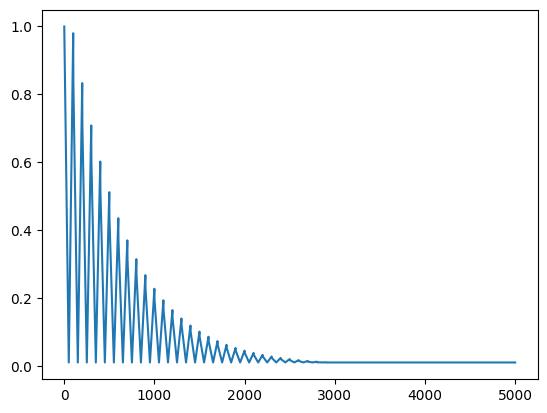

In [207]:
epsilons = [sawtooth_eps_decay(episode, decay_factor = 0.85, period=100) for episode in range(5000)]
plt.plot(epsilons)

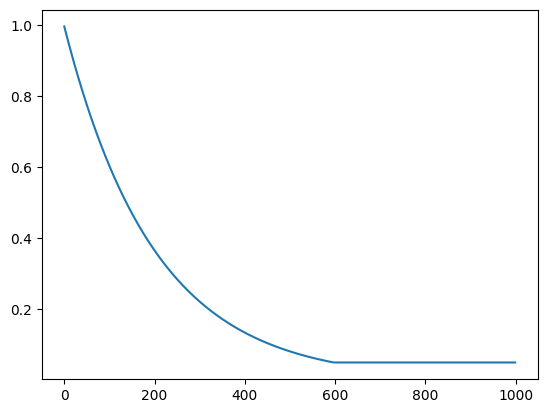

In [208]:
# Test the alternative epsilon decay function
eps_start = 1.0
eps_end = 0.05
eps_decay = 0.995
epsilons = []
eps = eps_start
for i in range(1000):
    eps = max(eps_end, eps_decay * eps)
    epsilons.append(eps)
plt.plot(epsilons)

In [209]:
#env_name = 'CartPole-v0' #Max episode length is 200
env_name = 'CartPole-v1' #Max episode length is 500
env = gym.make(env_name)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size, hidden_size=1024, seed=42)


In [210]:


n_episodes = 10000
max_t = 500
eps_start = 1.0
eps_end = 0.03
eps_decay = 0.85
eps_period = 100

scores = []
scores_window = deque(maxlen=100)
eps = eps_start
for i_episode in range(1, n_episodes + 1):
    state, info = env.reset()
    score = 0
    eps = sawtooth_eps_decay(i_episode, peak_eps=eps_start, min_eps=eps_end, period=eps_period, decay_factor=eps_decay)
    for t in range(max_t):
        action = agent.act(state, eps)
        next_state, reward, done, truncated, info = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        #print(f"Episode {i_episode}\tTimestep {t}\tScore: {score:.2f} \treward: {reward}")
        if done:
            break
    scores_window.append(score)
    scores.append(score)
    #eps = max(eps_end, eps_decay * eps)

    print(f"Episode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}\teps: {eps:.2f}\tlr: {agent.scheduler.get_last_lr()[0]:.6f}")

    if np.mean(scores_window) >= 500*0.9:
        print(f'\nEnvironment solved in {i_episode-100:d} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        break

#env.close()

Episode 1	Average Score: 9.00	eps: 0.98	lr: 0.000100
Episode 2	Average Score: 18.00	eps: 0.96	lr: 0.000100
Episode 3	Average Score: 16.00	eps: 0.94	lr: 0.000100
Episode 4	Average Score: 18.50	eps: 0.92	lr: 0.000100
Episode 5	Average Score: 18.20	eps: 0.90	lr: 0.000100
Episode 6	Average Score: 18.33	eps: 0.88	lr: 0.000100
Episode 7	Average Score: 17.71	eps: 0.86	lr: 0.000100
Episode 8	Average Score: 16.88	eps: 0.84	lr: 0.000100
Episode 9	Average Score: 17.33	eps: 0.83	lr: 0.000100
Episode 10	Average Score: 16.70	eps: 0.81	lr: 0.000100
Episode 11	Average Score: 16.45	eps: 0.79	lr: 0.000100
Episode 12	Average Score: 19.00	eps: 0.77	lr: 0.000100
Episode 13	Average Score: 18.54	eps: 0.75	lr: 0.000100
Episode 14	Average Score: 18.86	eps: 0.73	lr: 0.000100
Episode 15	Average Score: 18.33	eps: 0.71	lr: 0.000100
Episode 16	Average Score: 18.12	eps: 0.69	lr: 0.000100
Episode 17	Average Score: 18.35	eps: 0.67	lr: 0.000100
Episode 18	Average Score: 17.94	eps: 0.65	lr: 0.000100
Episode 19	Average S

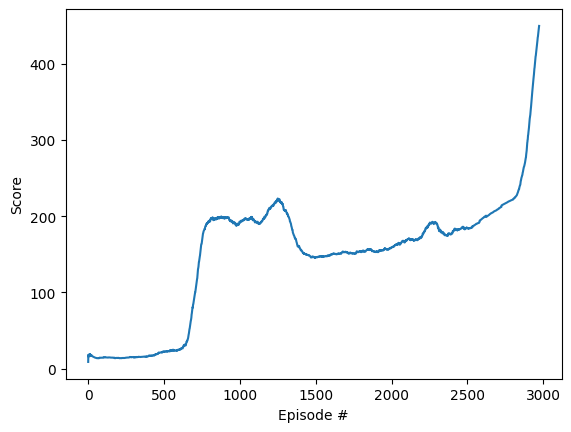

In [211]:
# plot the scores
# rolling average scores
rolling_average = [np.mean(scores[max(0, i-100):i+1]) for i in range(len(scores))]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(rolling_average)), rolling_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


In [212]:
def visualize_agent(agent, env, n_episodes=5):
    for i_episode in range(1, n_episodes + 1):
        state, info = env.reset()
        done = False
        score = 0
        max_t = 500
        t = 0
        while not done:
            env.render()
            action = agent.act(state)
            next_state, reward, done, truncated, info = env.step(action)
            state = next_state
            score += reward
            t += 1
            if done or t >= max_t:
                break
        print(f"Episode {i_episode}\tScore: {score}")
    env.close()

In [213]:
# Visualize the agent
#env.render_mode = "human"
env = gym.make('CartPole-v1', render_mode="human")
visualize_agent(agent, env)

Episode 1	Score: 500.0


KeyboardInterrupt: 

In [56]:
#Create a class for the schedule problem using the gym interface
class ScheduleGym():
    def __init__(self, num_days, num_hours, num_classes, num_subjects):
        self.num_days = num_days
        self.num_hours = num_hours
        self.num_classes = num_classes
        self.num_subjects = num_subjects
        self.num_slots = num_days * num_hours
        self.target_hours = np.zeros((num_classes, num_subjects), dtype=int) # Target hours for each class and subject
        self.schedule = -1*np.ones((num_classes, num_days, num_hours), dtype=int) # Schedule for each class, -1 means no subject assigned
        self.num_actions_left = 1000 #Number of actions left to take

        #This is to go from a one dimensional action space to a 4 dimensional action space
        #class_id, day, hour, subject_id
        self.max_values = np.array([num_classes, num_days, num_hours, num_subjects])
        self.cumprod_max_values = np.cumprod(self.max_values[::-1])[::-1]
        # self.decoder_base = np.cumprod(self.max_values)
        # self.encoder_base = np.flip(np.cumprod(np.flip(self.max_values)))
        self.initial_hours_to_assign = 0 #How many hours we have initially to assign, used to calculate score later

    def reset(self):
        for class_id in range(self.num_classes):
            for subject_id in range(self.num_subjects):
                self.target_hours[class_id, subject_id] = np.random.randint(1, 5)
        
        self.initial_hours_to_assign = self.target_hours.sum().sum()

        self.schedule = -1*np.ones((self.num_classes, self.num_days, self.num_hours), dtype=int) # Schedule for each class, -1 means no subject assigned
        self.num_actions_left = self.initial_hours_to_assign * 10 #Optimally we would need to take number of hours to assign steps to complete the schedule, lets give it some wiggle room
        
        #Return the current state,info
        info = {}
        #return (self.target_hours, self.schedule), info
        return self.state2vector(), info
    
    def state2vector(self):
        #Convert the state to a vector
        return np.concatenate([self.target_hours.flatten(), self.schedule.flatten()])
    
    def render(self):
        #Print the schedule
        for class_id in range(self.num_classes):
            print(f"Class {class_id + 1}:")
            for day in range(self.num_days):
                print(f"Day {day + 1}: {self.schedule[class_id, day]}")
            print()
        print(f'Fitness: {self.fitness()}, Actions left: {self.num_actions_left}')

        #print the target hours
        print("Target Hours:")
        for class_id in range(self.num_classes):
            print(f"Class {class_id + 1}: {self.target_hours[class_id]}")



    def decode_action(self, actions):
        actions = np.array(actions).reshape(-1) # Ensure numbers is a 1D column array
        aAll = np.zeros((actions.shape[0], len(self.max_values)), dtype=int)
        for i in range(len(self.max_values) - 1):
            aAll[:, i] = actions // self.cumprod_max_values[i+1]
            actions -= aAll[:, i]*self.cumprod_max_values[i+1]
        aAll[:,-1] = actions
        
        return aAll
    
    # Go from a 4D action to a 1D action
    def encode_action(self, actions):
        number = np.zeros(actions.shape[0], dtype=int)
        for i in range(len(self.max_values) - 1):
            number += actions[:,i]*self.cumprod_max_values[i+1]
        number += actions[:,-1]
        
        return number

            
    #next_state, reward, done, truncated, info = env.step(action)
    def step(self, action):
        # Update the schedule based on the action

        #Check if the action is a tuple or a single value
        if isinstance(action, tuple):
            #We are already in the decoded format
            class_id, day, hour, subject_id = action
        else:
            #Need to go from 1D to 4D
            decoded = self.decode_action(action).squeeze()
            class_id = decoded[0]
            day = decoded[1]
            hour= decoded[2]
            subject_id = decoded[3]
             
        
        #If subject_id is >= num_subjects then this is a remove action for the class_id, day, hour slot
        #If the slot is already occupied, then the old subject will be placed back into the target hours
        
        current_subject_id = self.schedule[class_id, day, hour]
 
        #The slot was already booked, lets reomove it (and all of its dependencies)
        if current_subject_id != -1:
            self.schedule[class_id, day, hour] = -1
            self.target_hours[class_id, current_subject_id] += 1

        
        #See if it is an add action
        if subject_id < self.num_subjects:
            #Yes its an add action, lets see if we have enough hours to actually add it
            if self.target_hours[class_id, subject_id] > 0:
                self.schedule[class_id, day, hour] = subject_id
                self.target_hours[class_id, subject_id] -= 1
            
        reward = 0
        self.num_actions_left -= 1
        done = self.is_done()  
        if done:
            reward += self.fitness()  #If we are done we get the full score of the schedule
        
        truncated, info = False, {} #To be implemented later if needed
        #Return the next state, reward, done, truncated and info
        #return (self.target_hours, self.schedule), reward, done, truncated, info
        return self.state2vector(), reward, done, truncated, info
           

    def is_done(self):
        #Check if the schedule is complete
        return np.all(self.target_hours == 0) or self.num_actions_left <= 0
    
    def get_action_sizes(self):
        #Return the sizes of the action space
        #return [self.num_classes, self.num_days, self.num_hours, self.num_subjects]
        return np.prod(self.max_values)
    
    def get_state_sizes(self):
        #Return the shapes of the state space
        #return self.target_hours.shape, self.schedule.shape
        return self.state2vector().shape

    
    def fitness(self):
        #Calculate the fitness of the schedule
        fitness = self.num_actions_left * 0.1 #We want to maximize the number of actions left
        # target hours remaining
        target_hours_remaining = self.target_hours.sum().sum()

        fitness -= target_hours_remaining * 10

        # Count the number of holes in the schedule, that is where no subject is assigned, but is surrounded by subjects
        # If there are no subjects assigned to the edges, that is not considered a hole
        num_holes = 0

        # Create shifted versions of the schedule to compare adjacent hours
        left_shifted = np.roll(self.schedule, shift=-1, axis=2)
        right_shifted = np.roll(self.schedule, shift=1, axis=2)

        # Identify holes: -1 in the current schedule, and not -1 in both the left and right shifted schedules
        # Avoid considering the edges by setting the comparison for the first and last hour to False
        holes = (self.schedule == -1) & (left_shifted != -1) & (right_shifted != -1)
        holes[:, :, 0] = False  # Ignore first hour edge cases
        holes[:, :, -1] = False  # Ignore last hour edge cases

        # Count the number of holes
        num_holes = np.sum(holes)

        fitness -= num_holes * 5

        return fitness




In [57]:
#scheduleEnv = ScheduleGym(num_days=5, num_hours=8, num_classes=1, num_subjects=5)
scheduleEnv = ScheduleGym(num_days=5, num_hours=8, num_classes=1, num_subjects=5)
print(f'Action sizes: {scheduleEnv.get_action_sizes()}')
state, info = scheduleEnv.reset()

Action sizes: 200


In [58]:
state.shape

(45,)

In [59]:
scheduleEnv.decode_action([3,4])

array([[0, 0, 0, 3],
       [0, 0, 0, 4]])

In [60]:
#class_id, day, hour, subject_id = action
state, reward, done, truncated, info = scheduleEnv.step([2])
print(f"Reward: {reward}")
print(f"Done: {done}")
scheduleEnv.render()

Reward: 0
Done: False
Class 1:
Day 1: [ 2 -1 -1 -1 -1 -1 -1 -1]
Day 2: [-1 -1 -1 -1 -1 -1 -1 -1]
Day 3: [-1 -1 -1 -1 -1 -1 -1 -1]
Day 4: [-1 -1 -1 -1 -1 -1 -1 -1]
Day 5: [-1 -1 -1 -1 -1 -1 -1 -1]

Fitness: -143.1, Actions left: 169
Target Hours:
Class 1: [4 4 0 4 4]


In [61]:
scheduleEnv.get_action_sizes()

200

In [62]:
scheduleEnv.get_state_sizes()

(45,)

In [63]:
class QScheduleNetwork(nn.Module):
    def __init__(self, input_shape, action_size, hidden_size=42, dropout=0.2):
        super().__init__()
        self.input_shapes = input_shape
        self.action_size = action_size

        self.fc1 = nn.Linear(input_shape, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        if len(x.shape) == 1:
            x = x.unsqueeze(0) # Add batch dimension
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
        #x = self.heads(x)
        #return x

In [64]:
input_shapes = scheduleEnv.get_state_sizes()
action_sizes = scheduleEnv.get_action_sizes()
input_shapes, action_sizes

((45,), 200)

In [65]:
model = QScheduleNetwork(input_shape=input_shapes[0], action_size=action_sizes, hidden_size=1024, dropout=0.0)

In [66]:
#Create a dummy input
#random input
# input_shapes = scheduleEnv.get_state_sizes()
# action_sizes = scheduleEnv.get_action_sizes()

# #Random torch tensor input
# x = (torch.randint(0,5, input_shapes[0], dtype=torch.float32), torch.randint(0,5, input_shapes[1], dtype=torch.float32))

# x
input_shape = scheduleEnv.get_state_sizes()
x = torch.randint(0, 5, (2, input_shape[0]), dtype=torch.float32)    
x



tensor([[1., 3., 0., 4., 3., 0., 1., 4., 2., 1., 1., 1., 2., 2., 0., 3., 2., 2.,
         1., 2., 2., 1., 4., 1., 3., 2., 3., 0., 2., 2., 3., 3., 0., 2., 2., 0.,
         3., 4., 4., 0., 1., 2., 4., 4., 3.],
        [2., 2., 4., 1., 0., 4., 2., 2., 2., 0., 2., 2., 3., 2., 0., 1., 2., 2.,
         0., 2., 4., 1., 4., 3., 1., 0., 0., 4., 1., 3., 2., 1., 4., 4., 0., 3.,
         4., 4., 2., 0., 0., 3., 2., 0., 4.]])

In [67]:
x = x.squeeze()
x.shape

torch.Size([2, 45])

In [68]:
outputs = model(x)
outputs.shape



torch.Size([2, 200])

In [69]:
outputs.cpu().data.numpy().shape

(2, 200)

In [70]:
ost = np.argmax(outputs.cpu().data.numpy(), axis=1)
ost

array([111, 111], dtype=int64)

In [71]:
class DQNSceduleAgent:
    def __init__(self, input_shape, action_size, hidden_size=512, seed=42):
        self.input_shape = input_shape
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QScheduleNetwork(input_shape=input_shape, action_size=action_size, hidden_size=hidden_size, dropout=0.0).to(device)
        self.qnetwork_target = QScheduleNetwork(input_shape=input_shape, action_size=action_size, hidden_size=hidden_size, dropout=0.0).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=1e-4)
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=1000, gamma=0.99)


        # Replay memory
        self.memory = ReplayBuffer(buffer_size=int(1e5), batch_size=64, seed=seed, device=device)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

        self.t_step = (self.t_step + 1) % 4
        loss = None
        if self.t_step == 0:
            if len(self.memory) > self.memory.batch_size:
                experiences = self.memory.sample()
                loss = self.learn(experiences, gamma=0.99)
        return loss

    def act(self, state, eps=0.):
        #inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in state]
        inputs = torch.tensor(state, dtype=torch.float32).to(device)
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(inputs)
        self.qnetwork_local.train()

        if random.random() > eps:
            return int(np.argmax(action_values.cpu().data.numpy(), axis=1))
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards.unsqueeze(1) + (gamma * Q_targets_next * (1 - dones).unsqueeze(1))

        Q_expected = self.qnetwork_local(states).gather(1, actions.unsqueeze(1))

        loss = F.mse_loss(Q_expected, Q_targets)


        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 2.42)
        self.optimizer.step()
        self.scheduler.step()  # Step the scheduler

        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau=1e-3)
        #detatch loss and return value
        return loss.item()

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


In [72]:
state.shape

(45,)

In [73]:
env = ScheduleGym(num_days=5, num_hours=8, num_classes=1, num_subjects=5)
agent = DQNSceduleAgent(input_shape=env.get_state_sizes()[0], action_size=env.get_action_sizes(), hidden_size=2048, seed=42)

In [74]:
agent.act(state, 1)

6

In [75]:

n_episodes = 1000
eps_start = 1.0
eps_end = 0.03
eps_decay = 0.995


scores = []
losses = []
scores_window = deque(maxlen=100)
eps = eps_start
for i_episode in range(1, n_episodes + 1):
    state, info = env.reset()
    score = 0
    eps = eps*eps_decay
    eps = max(eps_end, eps)
    done = False
    t = 0
    episode_loss = 0
    while not done:
        action = agent.act(state, eps)
        next_state, reward, done, truncated, info = env.step(action)

        single_loss = agent.step(state, action, reward, next_state, done)
        if single_loss is not None:
            episode_loss += single_loss
        state = next_state
        score += reward
        t += 1
        #print(f"Episode {i_episode}\tTimestep {t}\tScore: {score:.2f} \treward: {reward}")
        if done:
            break

    scores_window.append(score)
    scores.append(score)
    losses.append(episode_loss)
    #eps = max(eps_end, eps_decay * eps)

    print(f"Episode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}\tnum_steps: {t}\teps: {eps:.2f}\tlr: {agent.scheduler.get_last_lr()[0]:.6f} \tLoss: {episode_loss:.2f}")

    if np.mean(scores_window) >= 500*0.9:
        print(f'\nEnvironment solved in {i_episode-100:d} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        break


Episode 1	Average Score: -9.10	num_steps: 51	eps: 0.99	lr: 0.000100 	Loss: 0.00
Episode 2	Average Score: -4.35	num_steps: 16	eps: 0.99	lr: 0.000100 	Loss: 0.00
Episode 3	Average Score: -1.80	num_steps: 27	eps: 0.99	lr: 0.000100 	Loss: 4.72
Episode 4	Average Score: -0.62	num_steps: 31	eps: 0.98	lr: 0.000100 	Loss: 1.08
Episode 5	Average Score: -0.50	num_steps: 50	eps: 0.98	lr: 0.000100 	Loss: 0.64
Episode 6	Average Score: -0.02	num_steps: 36	eps: 0.97	lr: 0.000100 	Loss: 0.43
Episode 7	Average Score: -3.23	num_steps: 95	eps: 0.97	lr: 0.000100 	Loss: 0.62
Episode 8	Average Score: -3.19	num_steps: 29	eps: 0.96	lr: 0.000100 	Loss: 15.45
Episode 9	Average Score: -4.39	num_steps: 30	eps: 0.96	lr: 0.000100 	Loss: 18.76
Episode 10	Average Score: -3.66	num_steps: 21	eps: 0.95	lr: 0.000100 	Loss: 13.39
Episode 11	Average Score: -2.65	num_steps: 25	eps: 0.95	lr: 0.000100 	Loss: 3.52
Episode 12	Average Score: -2.21	num_steps: 44	eps: 0.94	lr: 0.000100 	Loss: 18.08
Episode 13	Average Score: -1.82	n

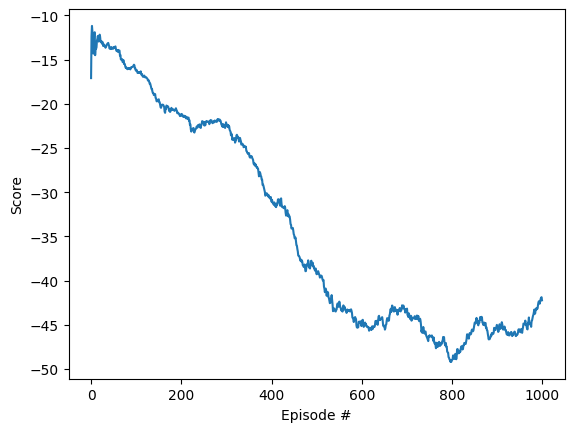

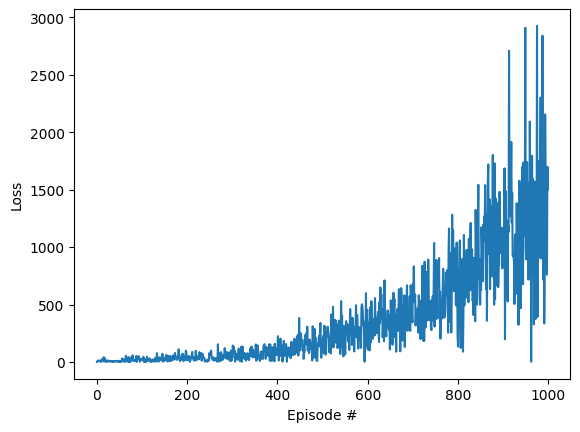

In [55]:
# plot the scores
# rolling average scores
rolling_average = [np.mean(scores[max(0, i-100):i+1]) for i in range(len(scores))]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(rolling_average)), rolling_average)
plt.ylabel('Score')
plt.xlabel('Episode #')

#Add loss plot
fig = plt.figure()
plt.plot(np.arange(len(losses)), losses)
plt.ylabel('Loss')
plt.xlabel('Episode #')
plt.show()

In [262]:
state, info = env.reset()
max_steps = 500
i = 0
while not env.is_done() and i < max_steps:
    action = agent.act(state, eps=0.01)
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state
    print(f"{i} Action: {action}, Reward: {reward}, fitness: {env.fitness()}")
    i += 1

env.render()

0 Action: 68, Reward: -1, fitness: -110
1 Action: 77, Reward: -1, fitness: -105
2 Action: 124, Reward: -1, fitness: -95
3 Action: 174, Reward: -1, fitness: -85
4 Action: 9, Reward: -1, fitness: -75
5 Action: 152, Reward: -1, fitness: -65
6 Action: 197, Reward: -1, fitness: -55
7 Action: 145, Reward: -1, fitness: -45
8 Action: 141, Reward: -1, fitness: -35
9 Action: 41, Reward: -1, fitness: -35
10 Action: 41, Reward: -1, fitness: -35
11 Action: 41, Reward: -1, fitness: -35
12 Action: 41, Reward: -1, fitness: -35
13 Action: 41, Reward: -1, fitness: -35
14 Action: 41, Reward: -1, fitness: -35
15 Action: 41, Reward: -1, fitness: -35
16 Action: 41, Reward: -1, fitness: -35
17 Action: 41, Reward: -1, fitness: -35
18 Action: 41, Reward: -1, fitness: -35
19 Action: 41, Reward: -1, fitness: -35
20 Action: 41, Reward: -1, fitness: -35
21 Action: 41, Reward: -1, fitness: -35
22 Action: 41, Reward: -1, fitness: -35
23 Action: 41, Reward: -1, fitness: -35
24 Action: 41, Reward: -1, fitness: -35
25 

In [248]:
env.render()

Class 1:
Day 1: [-1 -1  2 -1 -1 -1 -1 -1]
Day 2: [-1 -1 -1 -1 -1 -1 -1 -1]
Day 3: [-1 -1 -1 -1 -1  4  4 -1]
Day 4: [-1 -1 -1 -1 -1 -1 -1  4]
Day 5: [-1 -1 -1 -1 -1 -1 -1  4]

Fitness: -80
Target Hours:
Class 1: [2 3 1 2 0]
